In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, cv2, random
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers, Model
from tensorflow.keras.layers import (
    Dense, Dropout, Conv2D, MaxPooling2D,
    BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import ResNet50

# Set Up

In [2]:
# For reproducability
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # sets python, numpy, tf together

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Dec 16 13:44:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   37C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# this is to make sure tensorflow sees it
print("TensorFlow version:", tf.__version__)
print("GPUs available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# enable memory growth so that the GPU memory will be allocated only for what is needed for the runtime
# basically starts out small and if program asks for me it will give
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Enabled memory growth for {len(gpus)} GPU(s).")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found.")

Enabled memory growth for 1 GPU(s).


In [6]:
# this is for checking how much RAM you have available
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 56.9 gigabytes of available RAM

You are using a high-RAM runtime!


# Data Prep

- Load data from kaggle (use your API key)
- Check that all images are uniform size and normalized to [0,1]
- Organize into train/val/test folders


Go to this link if need to setup the API https://www.kaggle.com/docs/api

In [7]:
# ensure kaggle is installed
! pip install -q kaggle

In [8]:
import kagglehub
path = kagglehub.dataset_download("andrewmvd/medical-mnist")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'medical-mnist' dataset.
Path to dataset files: /kaggle/input/medical-mnist


In [9]:
print(f"Current working directory: {os.getcwd()}")
os.chdir('/kaggle/input')
print(f"New working directory: {os.getcwd()}")

Current working directory: /content
New working directory: /kaggle/input


# Dataset Info

In [10]:
class_names = ['AbdomenCT','BreastMRI','CXR','ChestCT','Hand','HeadCT']
class_labels = {name:i for i, name in enumerate(class_names)}
IMAGE_SIZE = (64, 64)

# Load Dataset Function


In [11]:
def load_data(path):
    images, labels = [], []

    print(f"Loading dataset from {path} ...")
    for folder in os.listdir(path): # Iterate through each folder corresponding to a category
        folder_path = os.path.join(path, folder)
        if not os.path.isdir(folder_path):
            continue # skip non-folder entries if any

        label = class_labels[folder]

        for file in tqdm(os.listdir(folder_path), desc=f"Folder: {folder}"): # Iterate through each image in the folder
            img_path = os.path.join(folder_path, file)

            img = cv2.imread(img_path) # Read and preprocess image
            if img is None:
                continue # skip bad reads if any

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMAGE_SIZE)

            images.append(img)
            labels.append(label)

    images = np.array(images, dtype=np.float32) / 255.0 # Convert to np arrays annd normalize
    labels = np.array(labels)

    return images, labels

# Load Dataset

In [12]:
DATA_PATH = path

X, y = load_data(DATA_PATH)
print("Dataset loaded:", X.shape, y.shape)

Loading dataset from /kaggle/input/medical-mnist ...


Folder: ChestCT: 100%|██████████| 10000/10000 [01:02<00:00, 160.48it/s]


Dataset loaded: (58954, 64, 64, 3) (58954,)


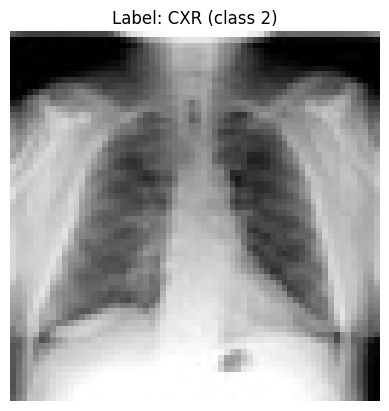

In [16]:
# just for selecting random image to view if you want to get a better idea of the data
i = np.random.randint(len(X))  # random valid index

img = X[i]
label_idx = y[i]
label_name = class_names[label_idx]

plt.imshow(img)
plt.title(f"Label: {label_name} (class {label_idx})")
plt.axis("off")
plt.show()# just for selecting random image to view if you want to get a better idea of the data
i = np.random.randint(len(X))  # random valid index

# Train/Val/Test Split + EDA

In [13]:
# check sizze of X and y
print('Shape of raw data: ', X.shape)
print('Shape of raw labels: ', y.shape)
print('Number of samples: ',X.shape[0])

Shape of raw data:  (58954, 64, 64, 3)
Shape of raw labels:  (58954,)
Number of samples:  58954


In [58]:
# check for duplicates
print('Number of duplicates: ', len(X) - len(np.unique(X,axis=0)))

Number of duplicates:  440


In [59]:
# now we remove the duplicate images from both X and y
X_unique, idx = np.unique(X, axis=0, return_index=True)
idx = np.sort(idx)
X_new = X[idx]
y_new = y[idx]

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y_new,
    test_size=0.20,
    random_state=SEED,
    stratify=y_new
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.20,
    random_state=SEED,
    stratify=y_train
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

Train: (37448, 64, 64, 3)
Val: (9363, 64, 64, 3)
Test: (11703, 64, 64, 3)


In [65]:
n_classes = 6

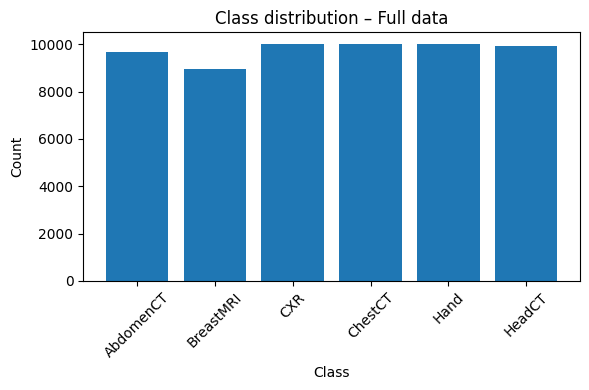

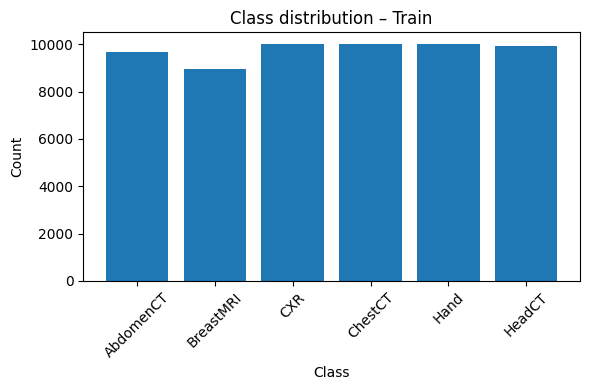

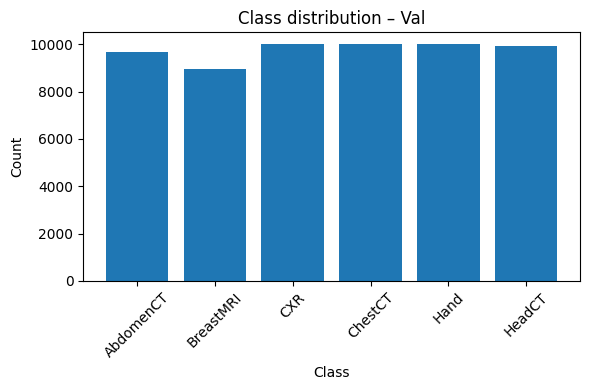

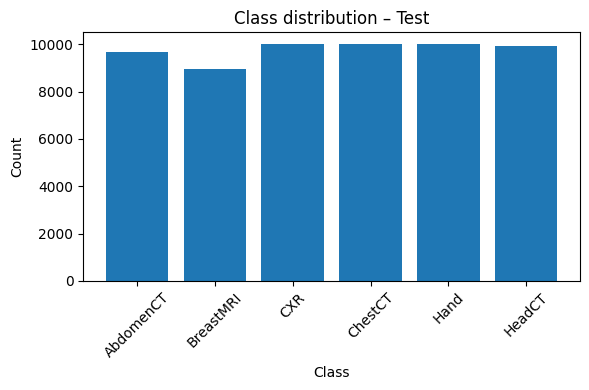

In [68]:
#just a helper func to get the clas distributions going
def plot_class_distribution(y, title):
    counts = np.bincount(y_new, minlength=n_classes)

    plt.figure(figsize=(6, 4))
    plt.bar(np.arange(n_classes), counts)
    plt.xticks(np.arange(n_classes), class_names, rotation=45)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Full dataset
plot_class_distribution(y_new, "Class distribution – Full data")

# Train
plot_class_distribution(y_train, "Class distribution – Train")

# Validation
plot_class_distribution(y_val, "Class distribution – Val")

# Test
plot_class_distribution(y_test, "Class distribution – Test")

#One Hot Encoding

In [69]:
# we will one hot encode the categoricals as we will use categorical cross entropy as loss func
y_train_oh = to_categorical(y_train, 6)
y_val_oh   = to_categorical(y_val, 6)
y_test_oh  = to_categorical(y_test, 6)

# MODEL #1

In [70]:
def build_cnn_model(input_shape=(64, 64, 3), num_classes=6):

    model = models.Sequential()

    # model base
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                            padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.20))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.20))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.20))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))

    # Softmax for multi-class classification
    model.add(layers.Dense(num_classes, activation='softmax'))
    loss = 'categorical_crossentropy'

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss=loss,
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )

    return model

model = build_cnn_model(input_shape=(64, 64, 3), num_classes=6)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [71]:
model.summary() # this is to show what our model looks like

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,192,198 (8.36 MB)

 Trainable params: 2,192,198 (8.36 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
history = model.fit(
    X_train, y_train_oh,
    validation_data=(X_val, y_val_oh),
    epochs=20,
    batch_size=64,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)])


Epoch 1/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9282 - auc: 0.9891 - loss: 0.2003 - val_accuracy: 0.9989 - val_auc: 0.9999 - val_loss: 0.0043
Epoch 2/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9977 - auc: 0.9997 - loss: 0.0109 - val_accuracy: 0.9989 - val_auc: 0.9999 - val_loss: 0.0050
Epoch 3/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9984 - auc: 0.9997 - loss: 0.0073 - val_accuracy: 0.9985 - val_auc: 0.9999 - val_loss: 0.0055
Epoch 4/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9968 - auc: 0.9997 - loss: 0.0124 - val_accuracy: 0.9990 - val_auc: 0.9999 - val_loss: 0.0038
Epoch 5/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9991 - auc: 1.0000 - loss: 0.0026 - val_accuracy: 0.9991 - val_auc: 0.9998 - val_loss: 0.0039
Epoch 6/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9978 - auc: 0.9997 - loss: 0.0084 - val_accuracy: 0.9994 - val_auc: 0.9999 - val_loss: 0.0034
Epoch 7/20
586/586 ━━━━━━━━━━━━━━━━━━━

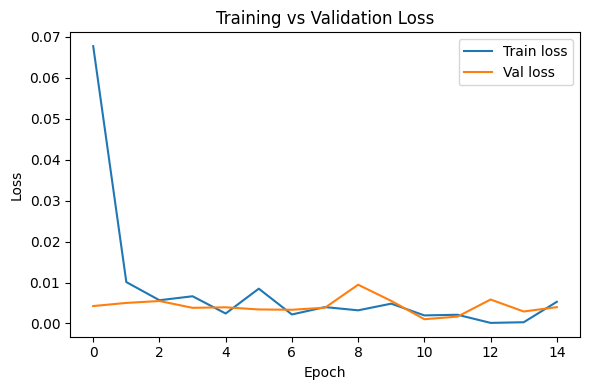

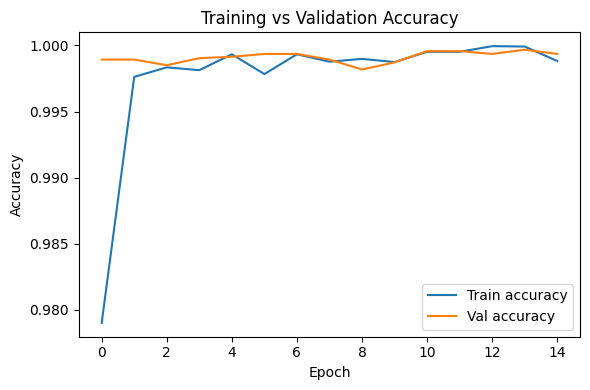

In [73]:
# helper func to show acc and loss curves
def plot_training_history(history):
    history_dict = history.history

    # loss
    plt.figure(figsize=(6, 4))
    plt.plot(history_dict['loss'], label='Train loss')
    plt.plot(history_dict['val_loss'], label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # accuracy

    acc_key = 'accuracy'
    val_acc_key = 'val_accuracy'

    plt.figure(figsize=(6, 4))
    plt.plot(history_dict[acc_key], label='Train accuracy')
    plt.plot(history_dict[val_acc_key], label='Val accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()


# call after training:
plot_training_history(history)

## Re-Train Model1 on Full Data
Happy with these curves, so we can proceed to retraining the model and evaluating on test set

In [74]:
# Combine train + val data for final training
X_full_train = np.concatenate([X_train, X_val], axis=0)
y_full_train = np.concatenate([y_train_oh, y_val_oh], axis=0)

print("Full training shape:", X_full_train.shape)
print("Full labels shape:", y_full_train.shape)

Full training shape: (46811, 64, 64, 3)
Full labels shape: (46811, 6)


In [75]:
# Clear the GPU/TF memory
tf.keras.backend.clear_session()

model1 = build_cnn_model(input_shape=(64, 64, 3), num_classes=6)

best_history = model1.fit(
    X_full_train, y_full_train,
    epochs=20,
    batch_size=64,
    validation_split=0.10,  # small split just to monitor overfitting
    shuffle=True,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])


Epoch 1/20
659/659 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9198 - auc: 0.9862 - loss: 0.2286 - val_accuracy: 0.9974 - val_auc: 0.9997 - val_loss: 0.0111
Epoch 2/20
659/659 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9966 - auc: 0.9999 - loss: 0.0111 - val_accuracy: 0.9989 - val_auc: 0.9999 - val_loss: 0.0071
Epoch 3/20
659/659 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9978 - auc: 0.9998 - loss: 0.0093 - val_accuracy: 0.9985 - val_auc: 0.9997 - val_loss: 0.0110
Epoch 4/20
659/659 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9988 - auc: 0.9999 - loss: 0.0042 - val_accuracy: 0.9989 - val_auc: 0.9999 - val_loss: 0.0059
Epoch 5/20
659/659 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9990 - auc: 0.9999 - loss: 0.0033 - val_accuracy: 0.9989 - val_auc: 0.9999 - val_loss: 0.0064
Epoch 6/20
659/659 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9983 - auc: 0.9999 - loss: 0.0059 - val_accuracy: 0.9987 - val_auc: 0.9999 - val_loss: 0.0057
Epoch 7/20
659/659 ━━━━━━━━━━━━━━━━━━━

## Loss/Acc Curves + Evaluate on Test

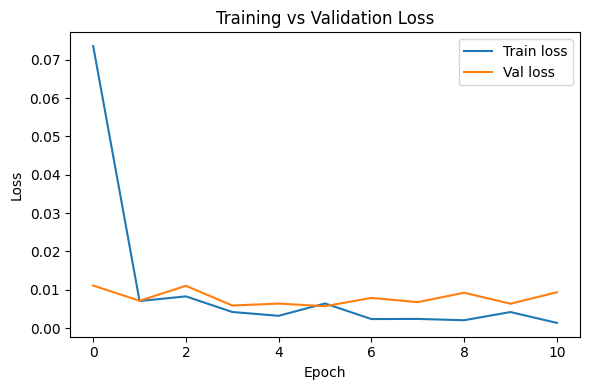

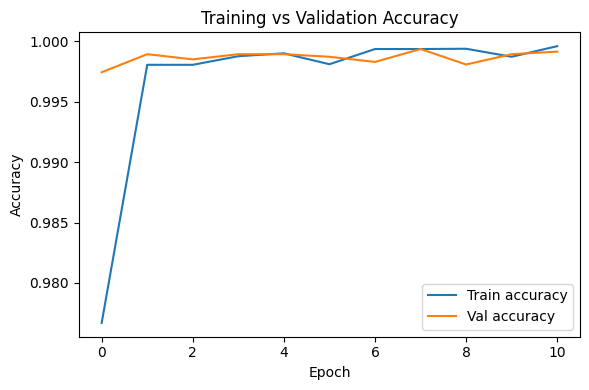

In [76]:
plot_training_history(best_history)

In [77]:
test_loss, test_acc, test_auc  = model1.evaluate(X_test, y_test_oh, verbose=1)

print("\n============ FINAL TEST RESULTS ============")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test AUC:      {test_auc:.4f}")
print("============================================")

366/366 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9986 - auc: 0.9999 - loss: 0.0041

============ FINAL TEST RESULTS ============
Test Accuracy: 0.9989
Test Loss:     0.0049
Test AUC:      0.9999


## Confusion Matrix

In [78]:
# Setup for confusion matrix

y_probability = model1.predict(X_test, batch_size=64) # will predict the class probs
y_pred = np.argmax(y_probability, axis=1) # will take the maximum probability for each example, then that becomes the predication
y_true = y_test # true labels, integer format

183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


<Figure size 800x600 with 0 Axes>

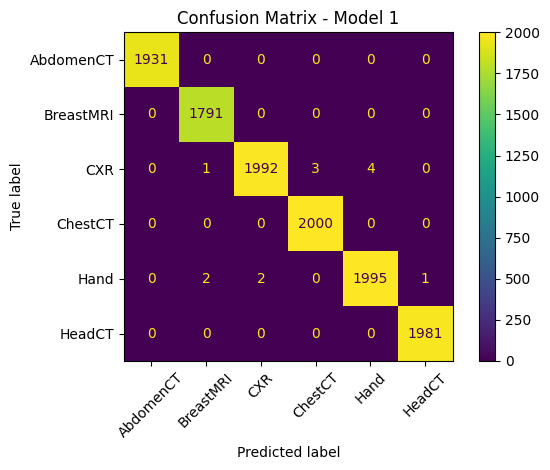

In [95]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# class name list in correct order
idx_to_class = {v: k for k, v in class_labels.items()}
class_names = [idx_to_class[i] for i in range(n_classes)]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix - Model 1")
plt.tight_layout()
plt.show()

## AUC-ROC Curves

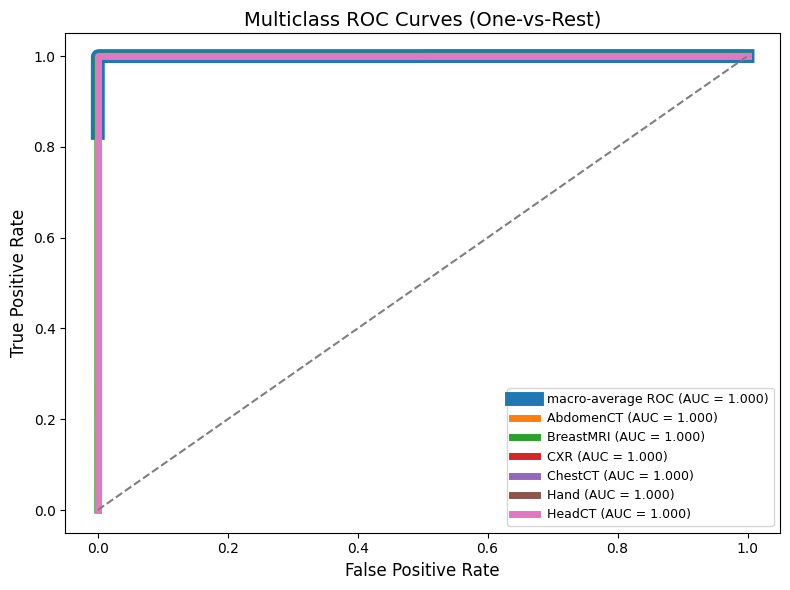

In [80]:
from sklearn.metrics import roc_curve, auc

# One-hot encode true labels for ROC
y_true_oh = tf.keras.utils.to_categorical(y_true, num_classes=n_classes)

# storage
fpr = {} # false pos rate
tpr = {} # true pos rate
roc_auc = {}

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_oh[:, i], y_probability[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# average ROC across all classes, also called the macro average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Macro-average (this will have a thicker line)
plt.plot(
    all_fpr, mean_tpr,
    label=f"macro-average ROC (AUC = {roc_auc['macro']:.3f})",
    linewidth=10
)

# Per-class curves (slightly thinner than macro)
for i in range(n_classes):
    plt.plot(
        fpr[i], tpr[i],
        label=f"{class_names[i]} (AUC = {roc_auc[i]:.3f})",
        linewidth=5
    )

# Chance line "how good is my model compared to random chance", in a way
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1.5)

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Multiclass ROC Curves (One-vs-Rest)", fontsize=14)
plt.legend(loc="lower right", fontsize=9)
plt.tight_layout()
plt.show()


## Example Classifications

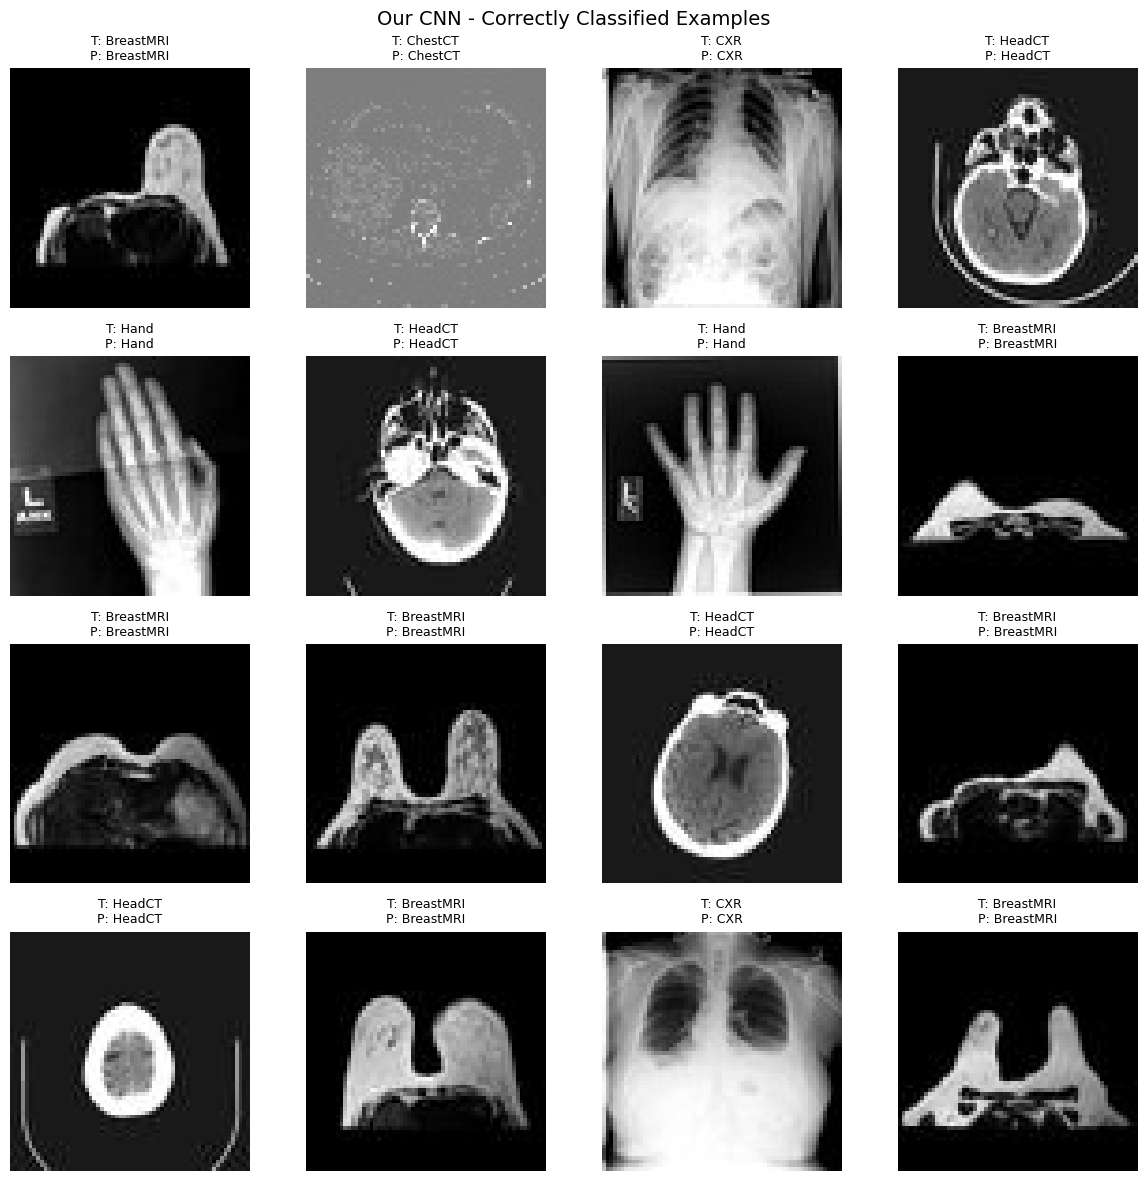

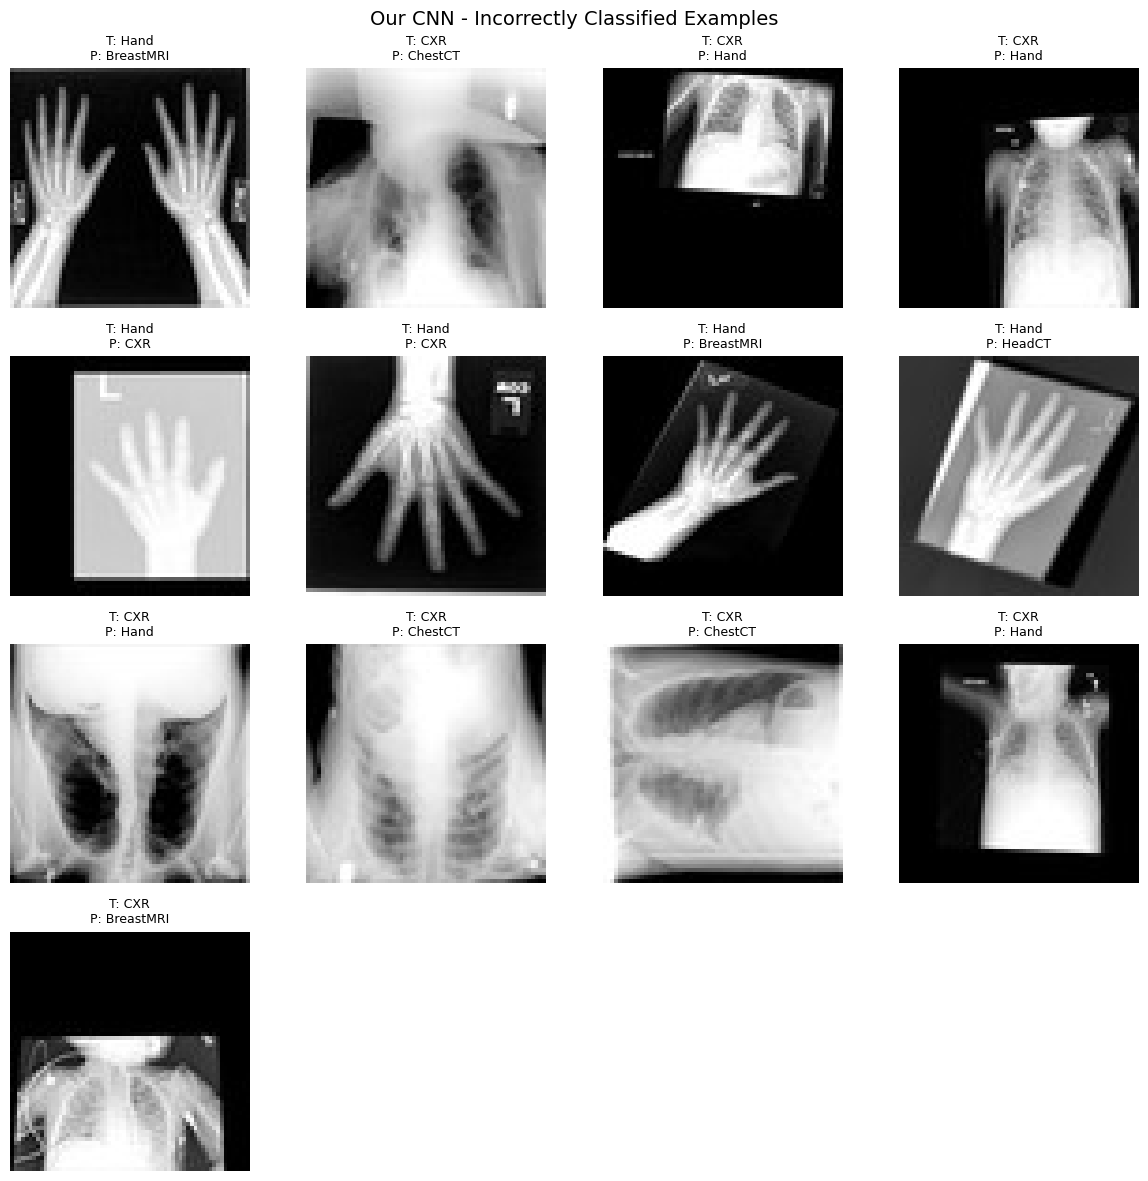

In [81]:
def get_predictions(model, images, batch_size=64):
    y_prob = model.predict(images, batch_size=batch_size, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    return y_prob, y_pred

def show_examples(y_true, y_pred, model_name, correct=True, max_images=16):
    if correct:
        idx = np.where(y_true == y_pred)[0]
        title = f"{model_name} - Correctly Classified Examples"
    else:
        idx = np.where(y_true != y_pred)[0]
        title = f"{model_name} - Incorrectly Classified Examples"

    if len(idx) == 0:
        print(f"No {'correct' if correct else 'incorrect'} examples found for {model_name}.")
        return

    # Shuffle indices so we don't always see the same class / first examples
    idx = np.random.permutation(idx)
    idx = idx[:max_images]

    n = len(idx)
    cols = 4
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(3*cols, 3*rows))
    for i, k in enumerate(idx):
        plt.subplot(rows, cols, i + 1)
        img = X_test[k]   # keep original images for visualization
        plt.imshow(img)
        true_label = class_names[y_true[k]]
        pred_label = class_names[y_pred[k]]
        plt.title(f"T: {true_label}\nP: {pred_label}", fontsize=9)
        plt.axis("off")
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

_, y_pred_best = get_predictions(model1, X_test)
show_examples(y_test, y_pred_best, "Our CNN", correct=True)
show_examples(y_test, y_pred_best, "Our CNN", correct=False)

# MODEL #2





In [86]:
def build_model2(input_shape=(64, 64, 3), num_classes=6):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3,3), padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.20))

    model.add(layers.Conv2D(64, (3,3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.20))

    model.add(layers.Conv2D(128, (3,3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.20))

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=optimizers.Adam(learning_rate=5e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )
    return model

model2 = build_model2()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [87]:
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,918 (370.77 KB)

 Trainable params: 94,470 (369.02 KB)

 Non-trainable params: 448 (1.75 KB)

#Train Model

In [91]:
history_m2 = model2.fit(
    X_train, y_train_oh,
    validation_data=(X_val, y_val_oh),
    epochs=20,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=3, restore_best_weights=True)], verbose=1)

Epoch 1/20
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9984 - auc: 1.0000 - loss: 0.0062 - val_accuracy: 0.9981 - val_auc: 0.9999 - val_loss: 0.0065
Epoch 2/20
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9996 - auc: 1.0000 - loss: 0.0022 - val_accuracy: 0.9954 - val_auc: 0.9998 - val_loss: 0.0146
Epoch 3/20
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9988 - auc: 1.0000 - loss: 0.0025 - val_accuracy: 0.9977 - val_auc: 0.9999 - val_loss: 0.0067
Epoch 4/20
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9995 - auc: 1.0000 - loss: 0.0018 - val_accuracy: 0.9998 - val_auc: 1.0000 - val_loss: 9.1509e-04
Epoch 5/20
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9995 - auc: 1.0000 - loss: 0.0016 - val_accuracy: 0.9999 - val_auc: 1.0000 - val_loss: 6.3012e-04
Epoch 6/20
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9993 - auc: 1.0000 - loss: 0.0017 - val_accuracy: 0.9999 - val_auc: 1.0000 - val_loss: 3.0802e-04
Epoch 7/20
1171

# Acc/Loss curves


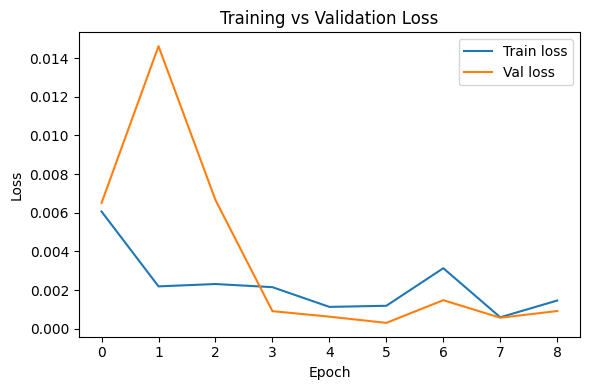

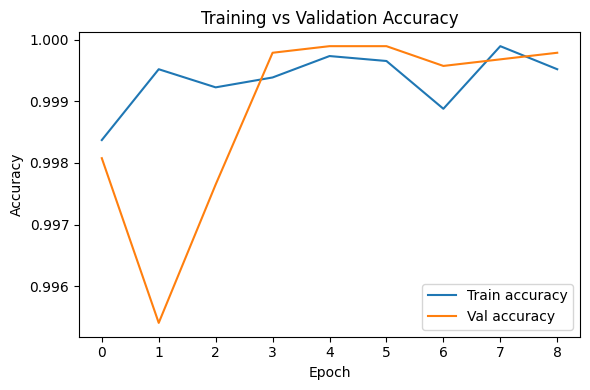

In [92]:
plot_training_history(history_m2)

# Evaluation

In [93]:
test_loss_2, test_acc_2, test_auc_2 = model2.evaluate(X_test, y_test_oh)

print("\n============ Model 2 TEST RESULTS ============")
print(f"Accuracy: {test_acc_2:.4f}")
print(f"Loss:     {test_loss_2:.4f}")
print(f"AUC:      {test_auc_2:.4f}")
print("===============================================")

366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9997 - auc: 0.9999 - loss: 0.0010

============ Model 2 TEST RESULTS ============
Accuracy: 0.9998
Loss:     0.0009
AUC:      0.9999


# CONFUSION MATRIX





366/366 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


<Figure size 700x600 with 0 Axes>

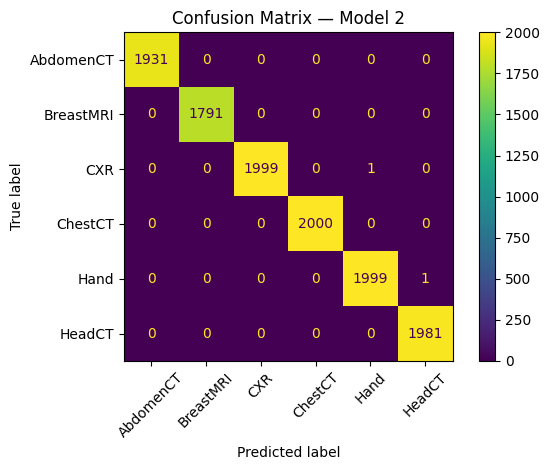

In [94]:
y_prob_r = model2.predict(X_test)
y_pred_r = np.argmax(y_prob_r, axis=1)

cm_r = confusion_matrix(y_test, y_pred_r)

plt.figure(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_r, display_labels=class_names)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix — Model 2")
plt.tight_layout()
plt.show()
